In [1]:
import numpy as np
import pandas as pd
import os
import sys
#sys.path.insert(0,'content/data')
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# We're going to use "listings"
data = pd.read_csv("drive/MyDrive/ML/bnb_data/listings.csv", engine = 'python')
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,2015,2695,3176,3309,7071,9991,14325,16401,16644,17409
name,Berlin-Mitte Value! Quiet courtyard/very central,Prenzlauer Berg close to Mauerpark,Fabulous Flat in great Location,BerlinSpot Schöneberg near KaDeWe,BrightRoom with sunny greenview!,Geourgeous flat - outstanding views,Apartment in Prenzlauer Berg,APARTMENT TO RENT,In the Heart of Berlin - Kreuzberg,Downtown Above The Roofs In Berlin
host_id,2217,2986,3718,4108,17391,33852,55531,59666,64696,67590
host_name,Ian,Michael,Britta,Jana,Bright,Philipp,Chris + Oliver,Melanie,Rene,Wolfram
neighbourhood_group,Mitte,Pankow,Pankow,Tempelhof - Schöneberg,Pankow,Pankow,Pankow,Friedrichshain-Kreuzberg,Friedrichshain-Kreuzberg,Pankow
neighbourhood,Brunnenstr. Süd,Prenzlauer Berg Nordwest,Prenzlauer Berg Südwest,Schöneberg-Nord,Helmholtzplatz,Prenzlauer Berg Südwest,Prenzlauer Berg Nordwest,Frankfurter Allee Süd FK,nördliche Luisenstadt,Prenzlauer Berg Südwest
latitude,52.534537,52.548513,52.534996,52.498855,52.543157,52.533031,52.547846,52.510514,52.504792,52.529071
longitude,13.402557,13.404553,13.417579,13.349065,13.415091,13.416047,13.405562,13.45785,13.435102,13.412843
room_type,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Private room
price,60,17,90,26,42,180,70,120,90,45


In [4]:
data['price'].isnull().values.any()

False

In [5]:
# Let's remove some columns
data = data.drop("id", axis = 1)
data = data.drop("name", axis = 1)
data = data.drop("host_id", axis = 1)
data = data.drop("host_name", axis = 1)
data = data.drop("neighbourhood_group", axis = 1)
data = data.drop("neighbourhood", axis = 1)
data = data.drop("last_review", axis = 1)
# data = data.drop("minimum_nights", axis = 1)
# data = data.drop("reviews_per_month", axis = 1)
# data = data.drop("availability_365", axis = 1)
# data = data.drop("room_type", axis = 1)

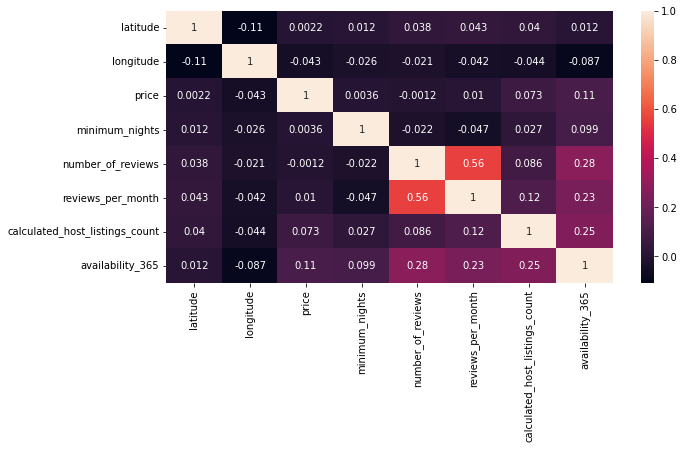

In [6]:
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

In [7]:
# Removing columns that have lower impact on the price
data = data.drop("number_of_reviews", axis = 1)
data = data.drop("minimum_nights", axis = 1)
data = data.drop("latitude", axis = 1)
data = data.drop("longitude", axis = 1)

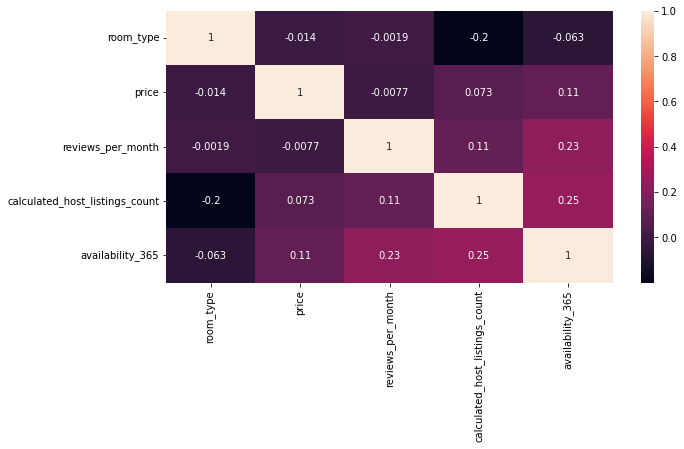

In [13]:
# Visualizing the correlation matrix again
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

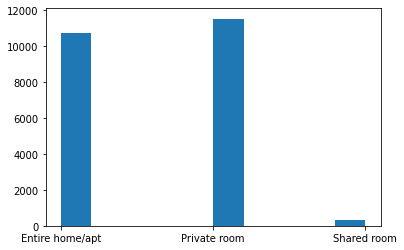

In [10]:
# Substituting "Entire home/apt", "Private room" and "Shared room" with their frequencies.
plt.hist(data.room_type)
apt_freq = np.array(data.room_type.value_counts())/data.shape[0]
data.room_type.replace(["Private room", "Entire home/apt", "Shared room"], apt_freq, inplace = True)

In [11]:
# Replacing NaN entires with "0"
data.fillna(0, inplace = True)

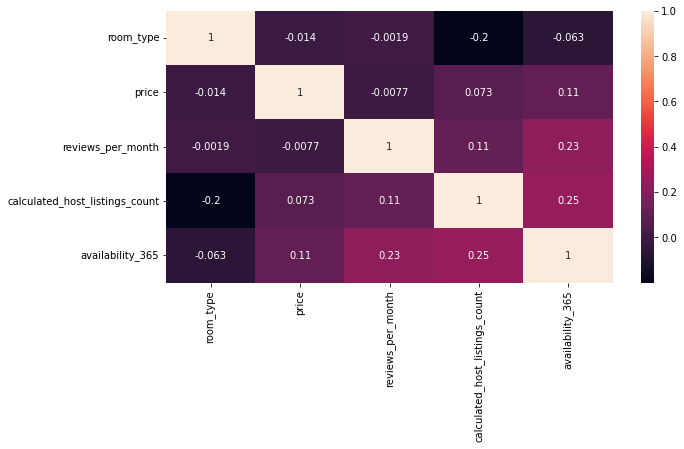

In [14]:
# Visualizing the correlation matrix again
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

In [51]:
# Let's remove the room type column too
data = data.drop("room_type", axis = 1)

(-100.0, 500.0)

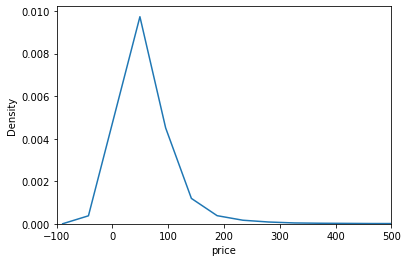

In [52]:
# Plotting price density plot to understand the distribution.
sns.kdeplot(data['price'])
plt.xlim(-100,500)
# plt.xscale('log')

(0.0, 500.0)

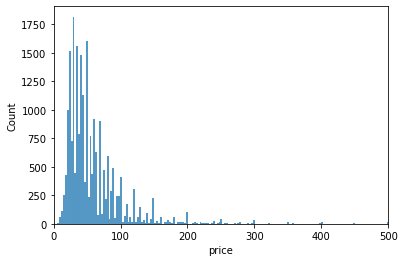

In [83]:
sns.histplot(data['price'])
plt.xlim(-0,500)

In [74]:
# Selecting rows in data with a condition on the 'price'
dataf = data[data['price'] < 70]
dataf = dataf[dataf['price'] > 20]
# dataf = data.copy()

In [75]:
# Dataset preparation
X = dataf.drop("price", axis = 1).values
y = dataf.price.values

#splitting Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [76]:
#standardization scaler - fit&transform on train, fit only on test
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(float))
X_test = s_scaler.transform(X_test.astype(float))

In [77]:
# Multiple Linear Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)

# predicting the test set result
y_pred_LR = regressor.predict(X_test)

# put results as a DataFrame
coeff_df = pd.DataFrame(regressor.coef_, data.drop('price', axis = 1).columns, columns = ['Coefficient'])
coeff_df

41.41819226664477
[ 0.25047597 -0.16613211  1.4882792 ]


,Coefficient
reviews_per_month,0.250476
calculated_host_listings_count,-0.166132
availability_365,1.488279


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-300.0, 500.0)

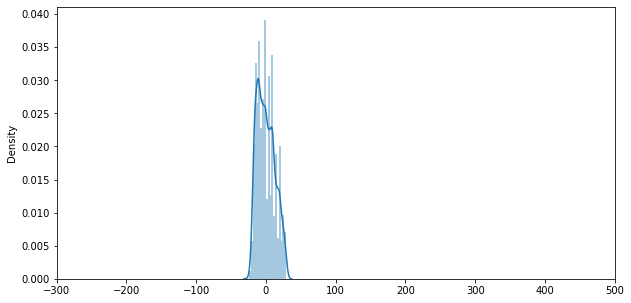

In [78]:
# visualizing residuals
# by visualizing the residual we can see that is normally distributed (proof of having linear relationship with the dependent variable)
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred_LR)
sns.distplot(residuals)
plt.xlim(-300, 500)

In [79]:
# compare actual output values with predicted values
y_pred_LR = regressor.predict(X_test)
df_LR = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_LR})
df_LR.head(10)

,Actual,Predicted
0,23,40.394553
1,39,40.374527
2,53,41.199386
3,39,44.620578
4,34,40.369066
5,31,40.416400
6,40,40.323312
7,30,40.369066
8,30,43.041192
9,60,40.520173


In [80]:
# evaluate the preformance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print("Mean absolute error:", metrics.mean_absolute_error(y_test, y_pred_LR))
# print("Mean squared error:", metrics.mean_squared_error(y_test, y_pred_LR))
print("Root of the mean squared error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR)))
print("Mean absolute percentage error: ", metrics.mean_absolute_percentage_error(y_test, y_pred_LR)*100, "%")

# print("VarScore:", metrics.explained_variance_score(y_test, y_pred_LR))
# que es explained variance score https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

Mean absolute error: 10.502108241017844
Root of the mean squared error: 12.453328207050587
Mean absolute percentage error:  28.06568665194514 %


In [41]:
# Ahora, modelemos con las redes neuronales
# https://towardsai.net/p/deep-learning/house-price-predictions-using-keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Dropout
from keras.layers import LeakyReLU
import tensorflow as tf

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
X_train = s_scaler.fit_transform(X_train.astype(float))
X_test = s_scaler.transform(X_test.astype(float))

In [43]:
model = Sequential()
model.add(Dense(15, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(50, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(15, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(50, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=10*0.001), loss = 'mse')

Epoch 1/500
1/1 [==============================] - 1s 689ms/step - loss: 5190.8979 - val_loss: 5140.8408
Epoch 2/500
1/1 [==============================] - 0s 34ms/step - loss: 5161.6865 - val_loss: 5110.9644
Epoch 3/500
1/1 [==============================] - 0s 33ms/step - loss: 5131.5762 - val_loss: 5068.3408
Epoch 4/500
1/1 [==============================] - 0s 31ms/step - loss: 5088.6729 - val_loss: 5007.3291
Epoch 5/500
1/1 [==============================] - 0s 34ms/step - loss: 5027.2905 - val_loss: 4922.0601
Epoch 6/500
1/1 [==============================] - 0s 37ms/step - loss: 4941.5386 - val_loss: 4806.6963
Epoch 7/500
1/1 [==============================] - 0s 32ms/step - loss: 4825.7769 - val_loss: 4654.7544
Epoch 8/500
1/1 [==============================] - 0s 35ms/step - loss: 4673.5991 - val_loss: 4459.2178
Epoch 9/500
1/1 [==============================] - 0s 35ms/step - loss: 4478.1074 - val_loss: 4213.1123
Epoch 10/500
1/1 [==============================] - 0s 32ms/ste

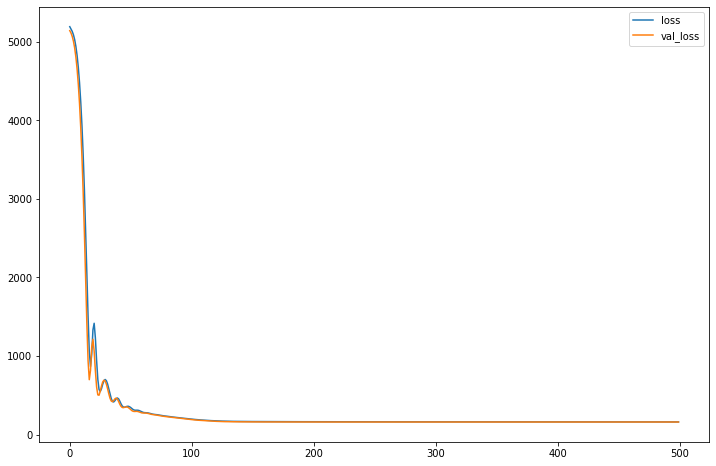

In [44]:
model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = X_train.shape[0], epochs = 500)

model.summary()

loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize = (12,8))

Mean absolute error: 10.638087856235789
Root of mean squared error: 12.667483265997662
Mean absolute percentage error: 15.251225967182938 %


(50.0, 100.0)

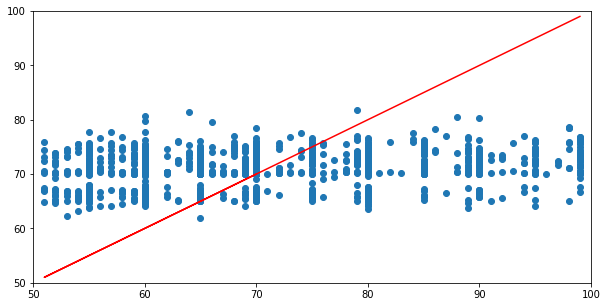

In [45]:
y_pred = model.predict(X_test)

from sklearn import metrics

print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))

# print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root of mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# print('VarScore:', metrics.explained_variance_score(y_test, y_pred))
print("Mean absolute percentage error:", metrics.mean_absolute_percentage_error(y_test, y_pred)*100, "%")

# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)

# Perfect predictions
plt.plot(y_test,y_test,'r')
plt.xlim(50, 100)
plt.ylim(50, 100)

In [ ]:
# NN predición
df_nn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.ravel()})
df_nn.head(10)

,Actual,Predicted
0,99,74.147255
1,75,70.658600
2,54,76.754807
3,55,74.971535
4,70,74.699135
5,76,71.623734
6,95,75.980270
7,85,71.978851
8,67,70.476845
9,55,77.360855


In [ ]:
# NN predición
df_nn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.ravel()})
df_nn.head(10)

,Actual,Predicted
0,99,74.147255
1,75,70.658600
2,54,76.754807
3,55,74.971535
4,70,74.699135
5,76,71.623734
6,95,75.980270
7,85,71.978851
8,67,70.476845
9,55,77.360855


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


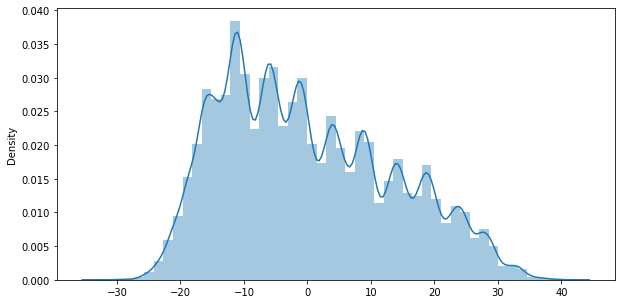

In [ ]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)

In [ ]:
#listings = pd.read_csv("data/listings.csv", engine = 'python')
#listings_summary = pd.read_csv("data/listings_summary.csv", engine = 'python', error_bad_lines=False)
#neighbourhoods = pd.read_csv("data/neighbourhoods.csv", engine = 'python')
#calendar_summary = pd.read_csv("data/neighbourhoods.csv", engine = 'python')
#reviews = pd.read_csv("data/reviews.csv", engine = 'python')
#reviews_summary = pd.read_csv("data/reviews_summary.csv", engine = 'python', error_bad_lines=False)

In [ ]:
#visualizing house prices
#fig = plt.figure(figsize = (10,7)) 
#fig.add_subplot(2, 1, 1)
#sns.distplot(data['price'])
#fig.add_subplot(2, 1, 2)
#sns.boxplot(data['price'])
#plt.tight_layout()

In [ ]:
# #visualizing the price dependence on the number of reviews, latitute and logitude
# fig = plt.figure(figsize = (16, 5))
# fig.add_subplot(2, 2, 1)
# sns.scatterplot(data['price'], data['number_of_reviews'])
# fig = plt.figure(figsize = (16, 5))
# fig.add_subplot(2, 2, 2)
# sns.scatterplot(data['price'], data['latitude'])
# fig = plt.figure(figsize = (16, 5))
# fig.add_subplot(2, 2, 3)
# sns.scatterplot(data['price'], data['longitude'])

In [ ]:
# fig = plt.figure(figsize = (16, 16))
# fig.add_subplot(2, 3, 1)
# sns.jointplot(x ='price', y ='latitude', data = data, kind ='kde')